In [24]:
from langchain_community.graphs import Neo4jGraph
from dotenv import load_dotenv
import os

load_dotenv()
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USER, password=NEO4J_PASSWORD)


In [28]:
# Drop old projection if it exists, then project fresh
graph.query("""
CALL gds.graph.exists('mof_shared_features') YIELD exists
WITH exists
CALL {
  WITH exists
  CALL apoc.do.when(
    exists,
    'CALL gds.graph.drop("mof_shared_features") YIELD graphName RETURN graphName',
    'RETURN "no-drop" AS graphName',
    {}
  ) YIELD value
  RETURN value.graphName AS dropped
}
RETURN dropped
""")

graph.query("""
CALL gds.graph.project(
  'mof_shared_features',
  ['MOF','Application','Property','Linker','Precursor','Solvent'],
  {
    IS_RECOMMENDED_FOR: { type: 'IS_RECOMMENDED_FOR', orientation: 'UNDIRECTED' },
    HAS_PROPERTY:       { type: 'HAS_PROPERTY',       orientation: 'UNDIRECTED' },
    USES:               { type: 'USES',               orientation: 'UNDIRECTED' }
  }
)

""")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (exists) { ... }} {position: line: 4, column: 1, offset: 71} for query: '\nCALL gds.graph.exists(\'mof_shared_features\') YIELD exists\nWITH exists\nCALL {\n  WITH exists\n  CALL apoc.do.when(\n    exists,\n    \'CALL gds.graph.drop("mof_shared_features") YIELD graphName RETURN graphName\',\n    \'RETURN "no-drop" AS graphName\',\n    {}\n  ) YIELD value\n  RETURN value.graphName AS dropped\n}\nRETURN dropped\n'


[{'nodeProjection': {'Application': {'label': 'Application', 'properties': {}},
   'Property': {'label': 'Property', 'properties': {}},
   'Precursor': {'label': 'Precursor', 'properties': {}},
   'Solvent': {'label': 'Solvent', 'properties': {}},
   'MOF': {'label': 'MOF', 'properties': {}},
   'Linker': {'label': 'Linker', 'properties': {}}},
  'relationshipProjection': {'IS_RECOMMENDED_FOR': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'IS_RECOMMENDED_FOR'},
   'HAS_PROPERTY': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'HAS_PROPERTY'},
   'USES': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'USES'}},
  'graphName': 'mof_shared_features',
  'nodeCount': 70763,
  'relationshipCount': 141504,
  'projectMillis': 30}]

In [37]:
# ==== 2) Community detection (flat / level-0) ====
graph.query("""
CALL gds.leiden.write(
  'mof_shared_features',
  { writeProperty: 'communityId' }   // unweighted; add relationshipWeightProperty:'weight' if you have it
)
YIELD communityCount, modularity
""")

[{'communityCount': 20463, 'modularity': 0.7452422727627188}]

In [38]:
# ==== 3) Materialize :Community nodes and connect MOFs ====
# - Create one Community per communityId
# - Link each MOF with [:IN_COMMUNITY]
graph.query("""
MATCH (m:MOF)
WHERE m.communityId IS NOT NULL
WITH m.communityId AS cid, collect(m) AS mofs
MERGE (c:Community {id: toString(cid)})
WITH c, mofs
UNWIND mofs AS m
MERGE (m)-[:IN_COMMUNITY]->(c)

""")

[]

In [39]:
# (Optional) prune tiny communities (keep only >= 2 MOFs)
graph.query("""
MATCH (c:Community)
OPTIONAL MATCH (c)<-[:IN_COMMUNITY]-(m:MOF)
WITH c, count(m) AS mcount
WHERE mcount < 2
DETACH DELETE c
""")

[]

In [40]:
community_info = graph.query("""
MATCH (c:Community)<-[:IN_COMMUNITY]-(m:MOF)
OPTIONAL MATCH (m)-[:IS_RECOMMENDED_FOR]->(a:Application)
WITH c, m, collect(DISTINCT a.name) AS apps
OPTIONAL MATCH (m)-[:HAS_PROPERTY]->(p:Property)
WITH c, m, apps, collect(DISTINCT p.name + ': ' + p.value + ' ' + coalesce(p.units,'')) AS props
OPTIONAL MATCH (t:Text)-[:MENTIONS|SUPPORTS|SYNTHESIZED_IN]->(m)
OPTIONAL MATCH (t)-[:HAS_SOURCE]->(src:Paper)
WITH c,
     collect(DISTINCT m.refcode) AS mofs,
     [x IN apps WHERE x IS NOT NULL] AS applications,
     [y IN props WHERE y IS NOT NULL] AS properties,
     [e IN collect(DISTINCT {type: t.type, text: t.text, doi: src.doi})
        WHERE e.text IS NOT NULL AND e.text <> '' AND e.text <> '<no justification>'] AS evidence
RETURN c.id AS communityId, mofs, applications, properties, evidence
ORDER BY communityId
""")

In [36]:
print(f"Communities fetched: {len(community_info)}")
print("Sample:", community_info[-1])


Communities fetched: 25900
Sample: {'communityId': '9619', 'mofs': ['PULHOT'], 'applications': ['Catalysis'], 'properties': ['Crystal System: Monoclinic ', 'Space Group: P21/n ', 'Cell Volume: 1510.1 Å³', 'Density: 2.31 g cm⁻³', 'Magnetic Susceptibility: 5.60 emu', 'Magnetic Moment: 6.69 μB per manganese cation', 'Thermal Stability: 19 %'], 'evidence': [{'text': 'The title compound [MnGa(PO3OH)2(PO4)][C6N2H14] was synthesized either as a pure polycrystalline phase (reaction (i)) or as single crystals (reaction (ii)) from predominantly nonaqueous systems under solvothermal conditions. In reaction (i), Ga2O3 (0.4 g), MnCl2·4H2O (0.88 g), and 1,4-diazabicyclo[2.2.2]octane (DABCO) (3.35 g) were dispersed in 5.95 cm³ of ethylene glycol by stirring. Orthophosphoric acid (2.35 cm³, 85 wt %) was then added with further stirring to give a gel with overall composition Ga2O3:2.1MnCl2·4H2O:16H3PO4:50HOCH2CH2OH:14DABCO. The gel was stirred until homogeneous, sealed in a Teflon-lined stainless steel

In [21]:
community_info[1400]

{'communityId': '12323',
 'mofs': ['LUMLIQ'],
 'applications': [],
 'properties': ['Synthesis Yield: 74 %',
  'Pore Volume: 9.3 %',
  'Topology: 4,4,5T14 '],
 'evidence': [{'text': 'This complex was obtained in a similar method to that of 1, but Zn(NO3)2·6H2O was replaced by Cd(NO3)2·4H2O (0.49g; 1.6mmol). Colorless crystals of 5 were obtained (yield: 0.298g, 74% based on Cd(NO3)2·4H2O).',
   'type': 'Synthesis Justification',
   'doi': '10.1016/j.ica.2015.05.003'},
  {'text': 'The void space was calculated using PLATON, suggesting 9.3% (168.0Å3) void volume to the total crystal volume.',
   'type': 'Property Justification',
   'doi': '10.1016/j.ica.2015.05.003'},
  {'text': 'Complex 5 consists of three dimensional (3D) (4,4,5)-connected net with 4,4,5T14 topology (Fig. 10b).',
   'type': 'Property Justification',
   'doi': '10.1016/j.ica.2015.05.003'},
  {'text': 'Colorless crystals of 5 were obtained (yield: 0.298g, 74% based on Cd(NO3)2·4H2O).',
   'type': 'Property Justification',


In [15]:
from tqdm import tqdm
from openai import OpenAI

# make sure your OPENAI_API_KEY is set in your environment
client = OpenAI()

summaries = []
for comm in tqdm(community_info[:10], desc="Summarizing communities"):  # adjust slice as needed
    content = f"""
Community ID: {comm['communityId']}

MOFs:
{', '.join(comm.get('mofs', []))}

Applications:
{', '.join([a for a in comm.get('applications', []) if a])}

Properties:
{', '.join([p for p in comm.get('properties', []) if p])}

Evidence (sampled justifications):
{" | ".join(comm.get('justifications', [])[:5])}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # or "gpt-5-nano" if you want faster/lighter
        messages=[
            {
                "role": "system",
                "content": (
                    "You are a scientific assistant specializing in MOFs. "
                    "Your task is to summarize research communities of MOFs discovered by graph clustering. "
                    "Explain why these MOFs are grouped together, highlighting shared applications, "
                    "chemical features, or property trends. "
                    "Be concise but emphasize the most distinct, non-trivial insights. "
                    "Incorporate textual justifications only if they provide useful evidence."
                )
            },
            {
                "role": "user",
                "content": f"Summarize the following MOF community:\n{content}"
            }
        ],
        temperature=0.4
    )

    summaries.append({
        "communityId": comm["communityId"],
        "summary": response.choices[0].message.content
    })

summaries


Summarizing communities: 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


[{'communityId': '12116',
  'summary': "**Community ID: 12116 Summary**\n\n**MOF:** XANZAQ\n\n**Applications:** Hydrogen Capture\n\n**Chemical Features and Properties:**\n- **Coordination Geometry:** The Cu2+ ion in XANZAQ exhibits a six-coordinated geometry, which is critical for stabilizing the framework and facilitating gas adsorption. The coordination involves four nitrogen atoms from Btz ligands and two μ2-Cl– anions, indicating a robust metal-ligand interaction that enhances structural integrity.\n- **Pore Volume:** With a pore volume of 45%, XANZAQ presents a significant capacity for gas storage, making it particularly suitable for applications in hydrogen capture. This high porosity is essential for maximizing the surface area available for adsorption.\n- **Thermal Stability:** The MOF demonstrates a remarkable thermal stability across a pH range of 1–13, which is advantageous for practical applications in varying environmental conditions. This stability ensures that the materi

          mofCount
count   497.000000
mean     80.619718
std     157.607178
min       2.000000
25%       2.000000
50%       3.000000
75%      92.000000
max    1122.000000


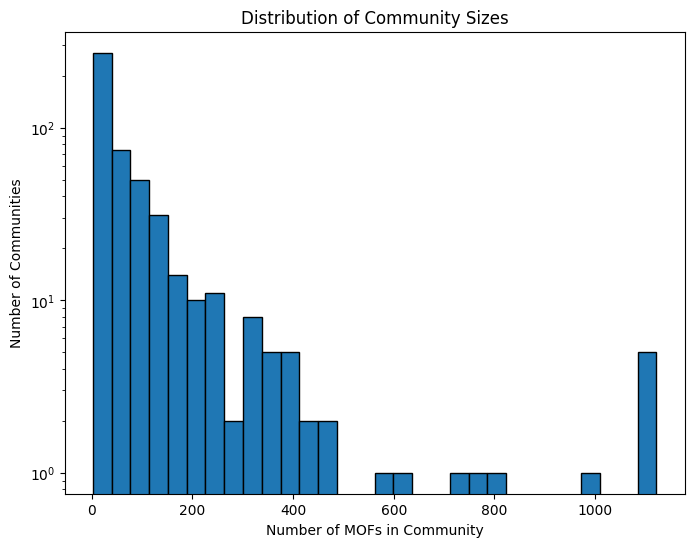

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# query Neo4j for community sizes
results = graph.query("""
MATCH (c:Community)<-[:IN_COMMUNITY]-(m:MOF)
WITH c, count(m) AS mofCount
RETURN c.id AS communityId, mofCount
""")

# convert to DataFrame
df = pd.DataFrame(results)

# quick stats
print(df.describe())

# histogram of community sizes
plt.figure(figsize=(8,6))
plt.hist(df["mofCount"], bins=30, edgecolor="black")
plt.xlabel("Number of MOFs in Community")
plt.ylabel("Number of Communities")
plt.title("Distribution of Community Sizes")
plt.yscale("log")  # often useful if distribution is heavy-tailed
plt.show()
